# Save your team

In spanish football league 20 teams face each other during the season. Each team plays 38 matches and get 3 points for a win, 1 point for a tie and 0 points for a loss. At the end of the season the three teams with the lowest performance fall to a lower division for the next year.

It is said that 41 points would save your team, and I am not sure if it is a calculated value or just a statistical value obtained from all previous seasons. We will know now using linear programming.

## Imports

We will need to import [PuLP](https://coin-or.github.io/pulp/) and other libraries.

In [1]:
from itertools import combinations, product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pulp

## Variables

We need two main variable groups:

- *points*: 20 integer variables to keep the points for each team.
- *matches*: 1140 binary variables to track the results for all matches, 380 matches and 3 possible results. It is like a onehot variable: only one of the third index must be 1. If index 0 is 1 then the first team won, if index 1 is 1 the it is a tie, and if index 3 is 1 then the second team won the game.

**NOTE**: for readability we will create more matches (20x20x3) but we need to discard a match of a team versus itself.

In [2]:
# indices for creating the variables
teams = [i for i in range(20)]
win_loss = [i for i in range(3)]

# two groups of variables
points = pulp.LpVariable.dicts('points', indices=teams, lowBound=0, cat='Integer')
matches = pulp.LpVariable.dicts('matches', indices=(teams, teams, win_loss), lowBound=0, upBound=1, cat='Binary')

## The problem

We need to maximize the points of the third worst team, so the cost is just the value of that variable.

In [3]:
# crate the model
model = pulp.LpProblem('save_your_team', sense=pulp.LpMaximize)

# cost
model += points[17]

## Constraints

- The first constraint says that just one result is possible for each match.
- The second constraint sum the points of every team and every match.
- The third constraint limit the points and keeps the order. First team must have at least the same points than the second. The second team at least the same points than the third, and so on.

In [4]:
# first constraint, itertools.combinations is used for avoiding matches of a team versus itself
for u, v in combinations(teams, r=2):
    model += pulp.lpSum([matches[u][v][k] for k in win_loss]) == 1
    model += pulp.lpSum([matches[v][u][k] for k in win_loss]) == 1

# second constraint, 3 points for a win, one point for a loss
for u in teams:
    opponents = [i for i in teams if i != u]
    model += points[u] == 3*pulp.lpSum([matches[u][v][0] for v in opponents]) +\
                          1*pulp.lpSum([matches[u][v][1] for v in opponents]) +\
                          1*pulp.lpSum([matches[v][u][1] for v in opponents]) +\
                          3*pulp.lpSum([matches[v][u][2] for v in opponents])

# third constraint
for u in teams[:-1]:
    model += points[u] >= points[u+1]

## Solution

Once the model is created with a cost and all the constraints we can solve it.

In [5]:
model.solve(pulp.PULP_CBC_CMD(msg=0))

print('Solution status =', pulp.constants.LpStatus[model.status])
print('Solution objective =', int(model.objective.value()))

Solution status = Optimal
Solution objective = 63


WOW!!! This is quite above the 41 points the press says. Let's create a DataFrame to see what happened.

In [6]:
# first we will create a 3D numpy array for simplifying the calculation
matches_np = np.zeros((20, 20, 3), dtype=np.int64)
for u, v, r in product(teams, teams, win_loss):
    if u != v:
        matches_np[u, v, r] = int(matches[u][v][r].varValue)


# empty DataFrame
df = pd.DataFrame()

# column with the position
df['position'] = [i for i in range(1, 21)]

# column for points
df['points'] = [int(points[u].varValue) for u in teams]

# column for wins
df['wins'] = matches_np[:,:,0].sum(axis=0) + matches_np[:,:,2].sum(axis=1)


# column for ties
df['ties'] = matches_np[:,:,1].sum(axis=0) + matches_np[:,:,1].sum(axis=1)


# column for losses
df['losses'] = matches_np[:,:,2].sum(axis=0) + matches_np[:,:,0].sum(axis=1)


df

,position,points,wins,ties,losses
0,1,63,17,0,21
1,2,63,17,0,21
2,3,63,17,0,21
3,4,63,17,0,21
4,5,63,17,0,21
5,6,63,17,0,21
6,7,63,17,0,21
7,8,63,17,0,21
8,9,63,17,0,21
9,10,63,17,0,21


This would be a really strange season but it makes sense. If you substract 4 wins (the four matches with the worst teams) it is a 18 teams league, and for maximizing the points for the last every team must win and loss the same number of matches.

It has been quite easier to code this with linear programming than trying to calculate combinations of results, removing equivalent combinations, etc.

And well, strictly speaking, 63 points may be not enough to save your team, so 64 points is the minimum.

## Simulations

Let's try to simulate many different results for the season and plot the points that would save your team.

In [7]:
def simulate(seasons=100000, n_teams=20):

    result = []

    for i in tqdm(range(seasons)):

        # random results
        matches = np.eye(3)[np.random.randint(low=0, high=3, size=(n_teams,n_teams))]

        # fix to zero matches of one team Vs itself
        for i in range(n_teams):
            matches[i,i,:] = np.zeros(3)

        # calculate points
        points = 3*(matches[:,:,0].sum(axis=0) + matches[:,:,2].sum(axis=1)) +\
                 1*(matches[:,:,1].sum(axis=0) + matches[:,:,1].sum(axis=1))

        # sort points
        points = np.sort(points)

        # add to result
        result.append(points[2])
        
    return np.array(result)

simulated = simulate(seasons=100000)

100%|██████████| 100000/100000 [00:07<00:00, 13077.47it/s]


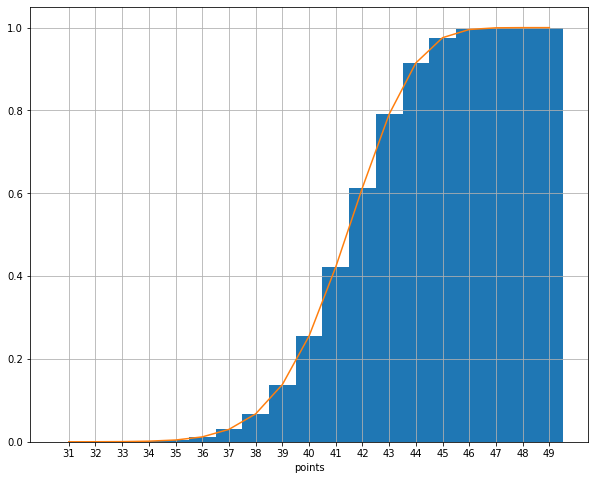

In [8]:
bins = np.arange(simulated.min(), simulated.max() + 2) - 0.5
bin_centers = np.arange(simulated.min(), simulated.max() + 1)

_ = plt.figure(figsize=(10,8))
_ = plt.hist(simulated, bins=bins, density=True, cumulative=True)
_ = plt.plot(bin_centers, np.histogram(simulated, bins=bins, density=True)[0].cumsum())
_ = plt.xticks(bin_centers)
_ = plt.grid()
_ = plt.xlabel('points')

So it looks like 41 points would lead your team to a lower division with about 60% (1 - 0.4) of probability. But we have simulated random matches with equal chances of win, tie or loss, no matter if one team is better. And the chances are not the same. So it is likely that the value of 41 points is just a historic result.